# Data Wrangling

## Problem statement
Context\
Raman spectroscopy could be an alteranative to PCR technique (current diagnostic method for SARS-CoV-2). Though PCR is a very sensitive, specific, an accrurate method, it might be time consuming in pendemic situations. Raman spectroscopy on other hand is cheap and quick method. 

In this project we develop a classification type machine learning model tha enables us to correctly diagnose SARS-CoV-2. 

Dataset\

- `covid_and_healthy_spectra.csv`
- `suspected_spectra.csv`

Acknowledgements:\
Yin, Gang; Li, Lintao; Lu, Shun; Yin, Yu; Su, Yuanzhang; Zeng, Yilan; et al. (2020): Data and code on serum Raman spectroscopy as an efficient primary screening of coronavirus disease in 2019 (COVID-19). figshare. Dataset. https://doi.org/10.6084/m9.figshare.12159924.v1


## Imports

Let us import all libraries here. One place to consult for notebook dependencies  

In [71]:
# Import libraries 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import datetime
from seaborn import heatmap
from library.sb_utils import save_file

## Load the covid spectral data

In [63]:
# set a path variable to the directory containing raman covid data:. ../raw_data/Raman_Covid
path = '../raw_data/Raman_Covid'
# Concatenate directory path to the file name: covid_path
covid_path = path + '/covid_and_healthy_spectra.csv'
# Load data file to a dataframe: covid_data
covid_data = pd.read_csv(covid_path)
# Preview content of file
covid_data.head()
# Load suspect data
suspect_data = pd.read_csv(path + '/suspected_spectra.csv');
suspect_data.shape
covid_data.head()

,400,402,405,407,410,412,415,417,420,422,...,2101,2103,2104,2105,2107,2108,2109,2111,2112,diagnostic
0,0.0,-0.015237,-0.030607,-0.038309,-0.039078,-0.035809,-0.031176,-0.030395,-0.033311,-0.031603,...,-0.000553,0.000118,0.000566,0.001245,0.000846,0.001106,0.001005,0.000117,0.0,Healthy
1,0.0,-0.012098,-0.028164,-0.035189,-0.036138,-0.031050,-0.026015,-0.027539,-0.028084,-0.027075,...,-0.000998,0.000278,-0.000123,0.000384,0.001010,0.000583,-0.000397,-0.000160,0.0,Healthy
2,0.0,-0.013000,-0.029058,-0.035021,-0.034994,-0.033025,-0.028413,-0.028470,-0.029737,-0.029198,...,-0.001554,0.000050,0.000866,0.000877,0.000871,0.001093,0.001058,0.000614,0.0,Healthy
3,0.0,-0.015728,-0.034346,-0.045140,-0.047671,-0.044334,-0.040807,-0.040474,-0.041417,-0.040699,...,-0.001541,-0.000198,0.000202,0.001023,0.000625,0.000420,0.000543,-0.000071,0.0,Healthy
4,0.0,-0.020355,-0.045839,-0.060556,-0.065805,-0.064988,-0.062097,-0.061955,-0.064759,-0.066886,...,-0.000088,0.000891,0.000942,0.001294,0.001878,0.001739,0.001946,0.001301,0.0,Healthy


## Explore the data

In [64]:
#Quickly audit data: covid_data.info()
covid_data.info()
covid_data.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Columns: 901 entries, 400 to diagnostic
dtypes: float64(900), object(1)
memory usage: 2.1+ MB


400           float64
402           float64
405           float64
407           float64
410           float64
               ...   
2108          float64
2109          float64
2111          float64
2112          float64
diagnostic     object
Length: 901, dtype: object

###  Count the number of missing data

In [6]:
#Count (using `.sum()`) the number of missing values (`.isnull()`) in each column of 
#covid_data as well as the percentages (using `.mean()` instead of `.sum()`).
#rder them (increasing or decreasing) using sort_values
#Call `pd.concat` to present these in a single table (DataFrame) with the helpful column names 'count' and '%'
missing = pd.concat([covid_data.isnull().sum(), 100 * covid_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing
#missing.sort_values(by='count',ascending=True)

,count,%
400,0,0.0
402,0,0.0
405,0,0.0
407,0,0.0
410,0,0.0
...,...,...
2108,0,0.0
2109,0,0.0
2111,0,0.0
2112,0,0.0


### Categorical features

Let us find and see all our categorial features.

In [73]:
#Use covid_data's `select_dtypes` method to select columns of dtype 'object'
covid_data.select_dtypes('object')

,diagnostic
0,Healthy
1,Healthy
2,Healthy
3,Healthy
4,Healthy
...,...
304,SARS-CoV-2
305,SARS-CoV-2
306,SARS-CoV-2
307,SARS-CoV-2


The only categorial feature in our data is column `diagnosis`

#### Unique categorical values
Let us see the unique categorial values of the feature `diagnostic`

In [75]:
#Use pandas' Series method `value_counts` to find any duplicated resort names
covid_data['diagnostic'].value_counts().head()

SARS-CoV-2    159
Healthy       150
Name: diagnostic, dtype: int64

The `diagnostic` feature has two unique values, namely: `SARS-Cov2` and `Healthy`. Our data consists of 159 Covid cases and 150 Healthy individuals.

#### Distribution of `diagnostic` categorical feature

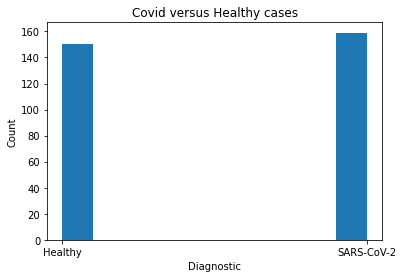

In [77]:
plt.hist(covid_data['diagnostic'])
plt.xlabel('Diagnostic')
plt.ylabel('Count')
plt.title('Covid versus Healthy cases')
plt.show()

### Numerical features

#### Distributions of numeric features

 We have 900 numerical features and generating all distirubtions at once may not efficient. Let us investigate the distribution of some selected numerical features.

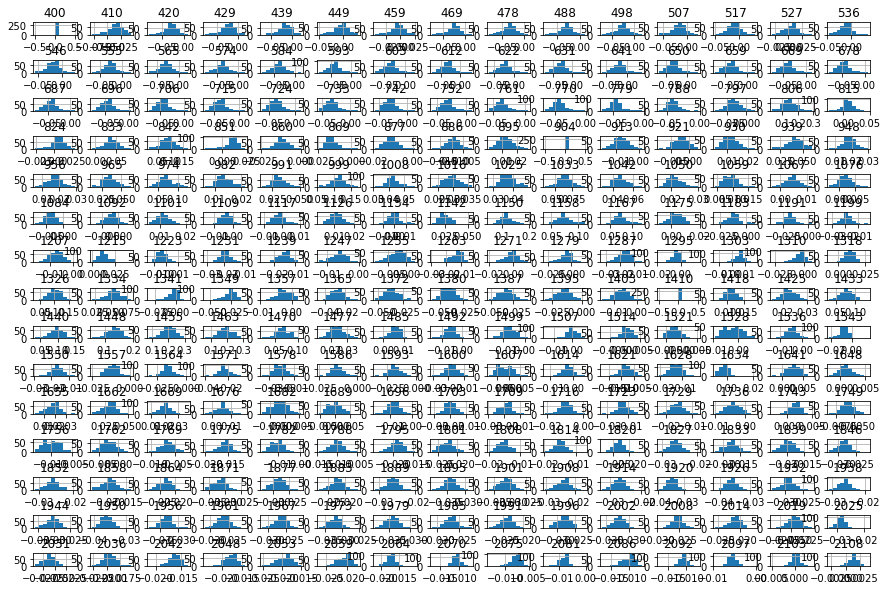

In [96]:
covid_data.iloc[:,0:901:4].hist(figsize=(15,10),bins=10)
plt.subplots_adjust(hspace=2);
plt.show()

What features do we have possible cause for concern about and why?

* several features like `400` because values are clustered down the low end,

It seems some features might have 0 values only. Let's find out which features display this behaviour.

#### Features with zero values

Get how many features we have with all zero values. 

In [164]:
# Get columns with all zero values
zero_covid_data = covid_data.loc[:, ~(covid_data != 0).any(axis=0)]
zero_covid_data.shape

(309, 9)

We have 9 features with all zero values. 

#### Distribution of zero numeric features

0.0    309
Name: 904, dtype: int64

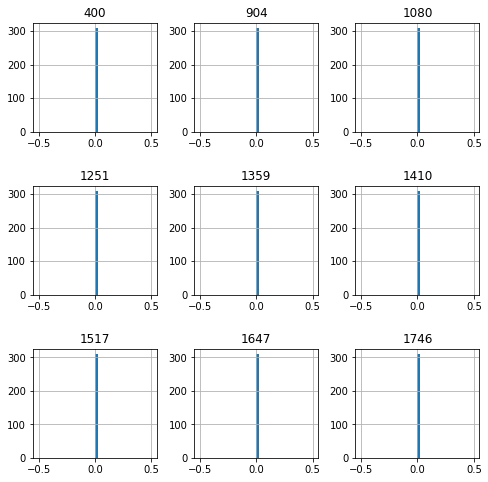

In [163]:
zero_covid_data.hist(figsize=(8,8),bins=40)
plt.subplots_adjust(hspace=0.5);
#plt.show()
zero_covid_data['904'].value_counts()

#### Drop zero features
We need to drop columns with all values zero.

In [166]:
# drop columns with all values zero: zeroFree_Covid_data
zeroFree_covid_data = covid_data.loc[:, (covid_data != 0).any(axis=0)]
zeroFree_covid_data.head()


,402,405,407,410,412,415,417,420,422,425,...,2101,2103,2104,2105,2107,2108,2109,2111,2112,diagnostic
0,-0.015237,-0.030607,-0.038309,-0.039078,-0.035809,-0.031176,-0.030395,-0.033311,-0.031603,-0.029029,...,-0.000553,0.000118,0.000566,0.001245,0.000846,0.001106,0.001005,0.000117,0.0,Healthy
1,-0.012098,-0.028164,-0.035189,-0.036138,-0.031050,-0.026015,-0.027539,-0.028084,-0.027075,-0.024482,...,-0.000998,0.000278,-0.000123,0.000384,0.001010,0.000583,-0.000397,-0.000160,0.0,Healthy
2,-0.013000,-0.029058,-0.035021,-0.034994,-0.033025,-0.028413,-0.028470,-0.029737,-0.029198,-0.027586,...,-0.001554,0.000050,0.000866,0.000877,0.000871,0.001093,0.001058,0.000614,0.0,Healthy
3,-0.015728,-0.034346,-0.045140,-0.047671,-0.044334,-0.040807,-0.040474,-0.041417,-0.040699,-0.036610,...,-0.001541,-0.000198,0.000202,0.001023,0.000625,0.000420,0.000543,-0.000071,0.0,Healthy
4,-0.020355,-0.045839,-0.060556,-0.065805,-0.064988,-0.062097,-0.061955,-0.064759,-0.066886,-0.065625,...,-0.000088,0.000891,0.000942,0.001294,0.001878,0.001739,0.001946,0.001301,0.0,Healthy


## End Data Wrangling
At this point the data wrangling is completed and a cleaned data should be saved.
### Save clean data

In [173]:
# save the data to a new csv file
datapath = '../data'
save_file(zeroFree_covid_data, 'covid_data_cleaned.csv', datapath)

Writing file.  "../data\covid_data_cleaned.csv"


# Exploratory data analysis

## Visualizing high dimensional data

### Scale the data
Scale the numerical data

In [202]:

#Create a new dataframe, `covid_scale` from `covid_data` whilst setting the index to 'diagnostic'
covid_data_scale = covid_data.set_index('diagnostic')
covid_data_index = covid_data_scale.index

#Save the column names (using the `columns` attribute) of `covid_data_scale` into the variable 'covid_data_columns'
covid_data_columns = covid_data_scale.columns
covid_data_scale.head()

,402,405,407,410,412,415,417,420,422,425,...,2100,2101,2103,2104,2105,2107,2108,2109,2111,2112
diagnostic,,,,,,,,,,,,,,,,,,,,,
Healthy,-0.015237,-0.030607,-0.038309,-0.039078,-0.035809,-0.031176,-0.030395,-0.033311,-0.031603,-0.029029,...,-0.001685,-0.000553,0.000118,0.000566,0.001245,0.000846,0.001106,0.001005,0.000117,0.0
Healthy,-0.012098,-0.028164,-0.035189,-0.036138,-0.031050,-0.026015,-0.027539,-0.028084,-0.027075,-0.024482,...,-0.002085,-0.000998,0.000278,-0.000123,0.000384,0.001010,0.000583,-0.000397,-0.000160,0.0
Healthy,-0.013000,-0.029058,-0.035021,-0.034994,-0.033025,-0.028413,-0.028470,-0.029737,-0.029198,-0.027586,...,-0.002707,-0.001554,0.000050,0.000866,0.000877,0.000871,0.001093,0.001058,0.000614,0.0
Healthy,-0.015728,-0.034346,-0.045140,-0.047671,-0.044334,-0.040807,-0.040474,-0.041417,-0.040699,-0.036610,...,-0.003241,-0.001541,-0.000198,0.000202,0.001023,0.000625,0.000420,0.000543,-0.000071,0.0
Healthy,-0.020355,-0.045839,-0.060556,-0.065805,-0.064988,-0.062097,-0.061955,-0.064759,-0.066886,-0.065625,...,-0.002151,-0.000088,0.000891,0.000942,0.001294,0.001878,0.001739,0.001946,0.001301,0.0


In [182]:
# Now use `scale()` to scale the above dataframe: 
covid_data_scale = scale(covid_data_scale)
type(covid_data_scale) # is numpy.ndarray

# Convert the numpy array to a dataframe
covid_data_scaled_df = pd.DataFrame(covid_data_scale, columns=covid_data_columns)
covid_data_scaled_df.head()

,402,405,407,410,412,415,417,420,422,425,...,2100,2101,2103,2104,2105,2107,2108,2109,2111,2112
0,0.029396,-0.169466,-0.307398,-0.298645,-0.220519,-0.089324,-0.057396,-0.199405,-0.153902,-0.143622,...,0.303745,0.267238,0.045011,-0.275664,0.052013,-0.617603,-0.261925,0.063182,-0.714883,-0.048027
1,0.675565,0.094517,-0.058681,-0.088368,0.110636,0.268129,0.137068,0.134956,0.123774,0.130376,...,-0.152282,-0.255200,0.224225,-1.041502,-0.875838,-0.441492,-0.882364,-1.648331,-1.110855,-0.048027
2,0.489933,-0.002139,-0.045266,-0.006537,-0.026791,0.102018,0.073686,0.029234,-0.006420,-0.056672,...,-0.859510,-0.907826,-0.031248,0.057741,-0.344697,-0.591279,-0.277629,0.127861,-0.004499,-0.048027
3,-0.071710,-0.573591,-0.852038,-0.913352,-0.813618,-0.756254,-0.743490,-0.717955,-0.711807,-0.600377,...,-1.468136,-0.893057,-0.309769,-0.680144,-0.187659,-0.856039,-1.075968,-0.501265,-0.983932,-0.048027
4,-1.024163,-1.815651,-2.081085,-2.210501,-2.250611,-2.230541,-2.205891,-2.211147,-2.317930,-2.348651,...,-0.227672,0.812778,0.912016,0.141430,0.104768,0.492144,0.489360,1.212373,0.977471,-0.048027


### PCA transformation

In [185]:
covid_pca = PCA().fit(covid_data_scale)

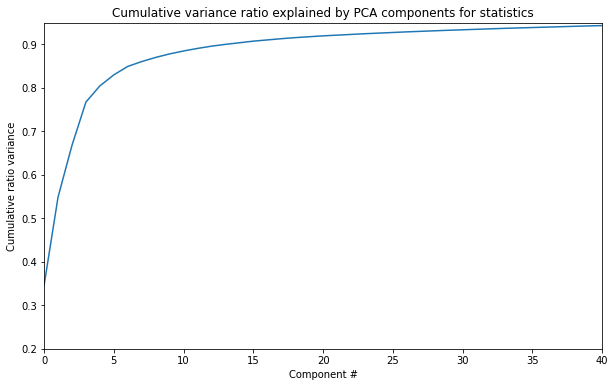

In [227]:
#Code task 6#
#Call the `cumsum()` method on the 'explained_variance_ratio_' attribute of `state_pca` and
#create a line plot to visualize the cumulative explained variance ratio with number of components
#Set the xlabel to 'Component #', the ylabel to 'Cumulative ratio variance', and the
#title to 'Cumulative variance ratio explained by PCA components for state/resort summary statistics'
#Hint: remember the handy ';' at the end of the last plot call to suppress that untidy output
plt.subplots(figsize=(10, 6))
plt.plot(covid_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.xlim(0.0,40)
plt.ylim(0.2,0.95)

plt.title('Cumulative variance ratio explained by PCA components for statistics');

In [201]:
#Code task 7#
#Call `state_pca`'s `transform()` method, passing in `state_summary_scale` as its argument
covid_pca_x = covid_pca.transform(covid_data_scale)
covid_pca_x.shape

(309, 309)

Plot the first two principal components and label and color each point with `H` for healthy and `S` for SARS-Cov .

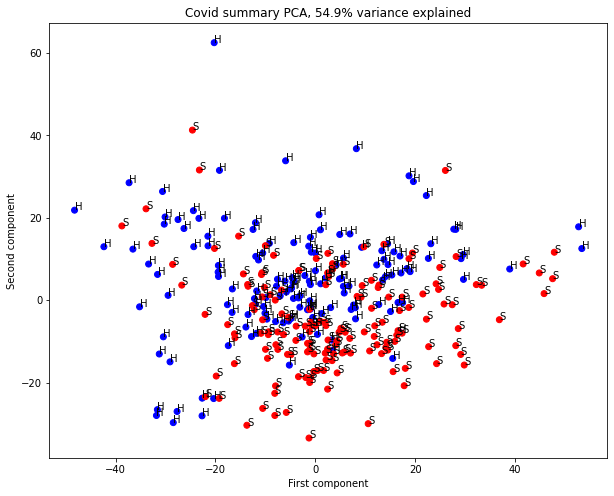

In [221]:
x = covid_pca_x[:, 0]
y = covid_pca_x[:, 1]
diagnostic = covid_data_index 
pc_var = 100 * covid_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
colors = {'Healthy':'blue', 'SARS-CoV-2':'red'}
plt.scatter(x=x, y=y,c=diagnostic.map(colors))
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Covid summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip(diagnostic, x, y):
    plt.annotate(s[0], (x, y))



In [228]:
# Get number of columns and number of rows: ncols, nrows
covid_data = zeroFree_covid_data
ncols = covid_data.shape[1]
nrows = covid_data.shape[0]
nrows,ncols

(309, 892)

In [229]:
# Split data into dependent and independent variables
X = np.matrix(covid_data.iloc[:,0:ncols-1].values)
y = np.array(covid_data.iloc[:,ncols-1].values) 
labels = list(set(y))
labels

['Healthy', 'SARS-CoV-2']

C:\Users\iabra\anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:447: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
C:\Users\iabra\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(1, 891)


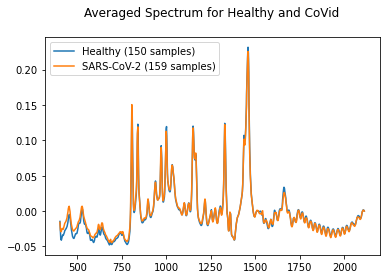

In [230]:
X_names = list(map(float, covid_data.columns.values[0:ncols-1])) # X_names = np.array(list(da
#print(X_names)
for c in labels: 
#    if c == 'Healthy':
        Xc = X[y == c]
        yc = y[y == c] 
        plt.plot(X_names, np.mean(Xc,axis=0).tolist()[0], label=  str(c) +  
                 ' (' + str(len(yc)) + ' samples)')
        plt.legend()
    
plt.title(u'Averaged Spectrum for Healthy and CoVid\n') ;  
print(np.mean(X[y==1],axis=0).shape)

In [231]:
# Encode the categorical data
from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder()
covid_data.iloc[:,ncols-1] = labelencoder_y.fit_transform(covid_data.iloc[:,ncols-1].values)

In [232]:
# split data into 75% training and 25% test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [233]:
# Scale the data 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_tr_scaled = sc.fit_transform(X_train)
X_te_scaled = sc.fit_transform(X_test)

In [234]:
# Compute a function for modeles
def models(X_train,Y_train):
        #logistic regression
        from sklearn.linear_model import LogisticRegression
        log = LogisticRegression(random_state=0)
        log.fit(X_train,y_train)
        #Decision tree
        from sklearn.tree import DecisionTreeClassifier
        tree = DecisionTreeClassifier(criterion='entropy',random_state=0)
        tree.fit(X_train,y_train)
        #Random Forest
        from sklearn.ensemble import RandomForestClassifier
        forest = RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=0)
        forest.fit(X_train,y_train)
        #print the models accuracy
        print('[0] Logistic Regression Accuracy: ', log.score(X_train,y_train))
        print('[0] Decision Tree Accuracy: ', tree.score(X_train,y_train))
        print('[0] Random Forest Accuracy: ', forest.score(X_train,y_train))
        return log,tree,forest

model = models(X_tr_scaled,y_train)

[0] Logistic Regression Accuracy:  1.0
[0] Decision Tree Accuracy:  1.0
[0] Random Forest Accuracy:  0.9956709956709957


Model:  LogisticRegression
Testing accuracy:  0.9615384615384616




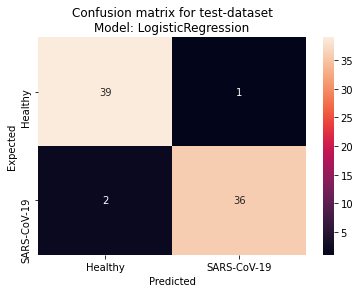

Model:  DecisionTreeClassifier
Testing accuracy:  0.8717948717948718




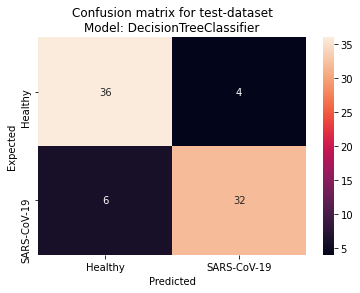

Model:  RandomForestClassifier
Testing accuracy:  0.9615384615384616




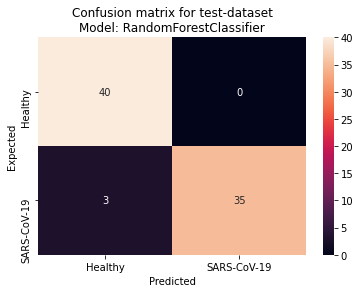

In [236]:
# Test on test data set

from sklearn.metrics import confusion_matrix
for i in range(len(model)):
    model_label = str(model[i]).split('(')
    cm = confusion_matrix(y_test,model[i].predict(X_te_scaled))
    print('Model: ',model_label[0])
    TP = cm[0][0]
    TN = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]
    Accuracy = (TN + TP)/(TN+TP+FN+FP)
    print('Testing accuracy: ', Accuracy)
    print('\n')
    if i==0:
        heatmap(cm, annot=True, fmt="g", yticklabels=["Healthy", "SARS-CoV-19"] ,xticklabels=["Healthy", "SARS-CoV-19"])
        plt.title("Confusion matrix for test-dataset" +  "\n"  + "Model: " + model_label[0])
        plt.xlabel("Predicted")
        plt.ylabel("Expected")
        plt.show()
    elif i == 1:
        heatmap(cm, annot=True, fmt="g", yticklabels=["Healthy", "SARS-CoV-19"] ,xticklabels=["Healthy", "SARS-CoV-19"])
        plt.title("Confusion matrix for test-dataset" +  "\n"  + "Model: " + model_label[0])
        plt.xlabel("Predicted")
        plt.ylabel("Expected")
        plt.show()
    else:
        heatmap(cm, annot=True, fmt="g", yticklabels=["Healthy", "SARS-CoV-19"] ,xticklabels=["Healthy", "SARS-CoV-19"])
        plt.title("Confusion matrix for test-dataset" +  "\n"  + "Model: " + model_label[0])
        plt.xlabel("Predicted")
        plt.ylabel("Expected")
        plt.show()

In [237]:
#Code task 22#
#Define a pipeline comprising the steps:
#SimpleImputer() with a strategy of 'median'
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
                      StandardScaler(),
                      RandomForestClassifier(random_state=47)
                        )

In [238]:
 #Code task 23#
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [239]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.95744681, 0.93478261, 0.97826087, 0.82608696, 0.91304348])

In [240]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.9219241443108233, 0.05265863496785462)

In [241]:
RF_pipe.get_params().keys() 

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'randomforestclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [242]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
            'randomforestclassifier__n_estimators': n_est,
            'standardscaler': [StandardScaler(), None]
            #'simpleimputer__strategy': ['mean', 'median']
             }
grid_params

{'randomforestclassifier__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(copy=True, with_mean=True, with_std=True),
  None]}

In [243]:
#Code task 24#
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [245]:
#Code task 25#
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                   

In [246]:
#Code task 26#
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestclassifier__n_estimators': 483,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [247]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.93617021, 0.93478261, 1.        , 0.84782609, 0.95652174])

In [248]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.9350601295097132, 0.049575951729881135)

In [249]:
X_df = pd.DataFrame(X_train)

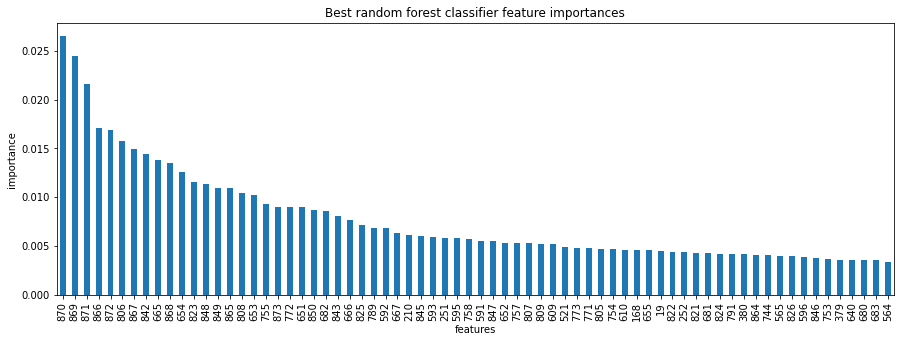

In [254]:
#Code task 27#
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
#print(len(X_train.columns))
plt.subplots(figsize=(15, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_
#print(imps)
rf_feat_imps = pd.Series(imps, index=X_df.columns).sort_values(ascending=False)
rf_feat_imps[0:70].plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

In [255]:
#Code task 22#
#Define a pipeline comprising the steps:
#SimpleImputer() with a strategy of 'median'
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 47
log_pipe = make_pipeline(
                        StandardScaler(),
                        LogisticRegression(random_state=47)
                        )

In [257]:
#Code task 23#
  #Call `cross_validate` to estimate the pipeline's performance.
   #Pass it the random forest pipe object, `X_train` and `y_train`,
  #and get it to use 5-fold cross-validation
log_default_cv_results = cross_validate(log_pipe, X_train, y_train, cv=5)

In [259]:
log_cv_scores = log_default_cv_results['test_score']
log_cv_scores

array([0.95744681, 0.93478261, 1.        , 0.93478261, 0.95652174])

In [260]:
np.mean(log_cv_scores), np.std(log_cv_scores)

(0.9567067530064755, 0.02381689885375297)

In [261]:
#n_est = [int(n) for n in np.logspace(start=1, stop=7, num=50)]
#grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
n_C = [int(n) for n in np.logspace(-3,3,10)]
penalty = ['l1', 'l2', 'elasticnet', 'none']
grid_params = {
                'logisticregression__C': n_C,
                'standardscaler': [StandardScaler(), None],
                'logisticregression__penalty': penalty
                 #'simpleimputer__strategy': ['mean', 'median']
              }
grid_params

{'logisticregression__C': [0, 0, 0, 0, 0, 2, 10, 46, 215, 1000],
 'standardscaler': [StandardScaler(copy=True, with_mean=True, with_std=True),
  None],
 'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none']}

In [262]:
#Code task 24#
#Call `GridSearchCV` with the logistic regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
log_grid_cv = GridSearchCV(log_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
log_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'logisticregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

In [263]:
#Code task 25#
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
log_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_clas

In [53]:
#Code task 26#
#Print the best params (`best_params_` attribute) from the grid search
log_grid_cv.best_params_

{'logisticregression__C': 1000,
 'logisticregression__penalty': 'l2',
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [54]:
log_best_cv_results = cross_validate(log_grid_cv.best_estimator_, X_train, y_train, cv=5)
log_best_scores = log_best_cv_results['test_score']
log_best_scores
log_grid_cv.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=47,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [264]:
np.mean(log_best_scores), np.std(log_best_scores)

(0.9610545790934321, 0.021265331048492618)

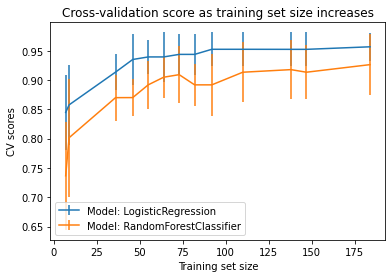

In [265]:
lab = [log_pipe, 'DT_pipe',RF_pipe]
fractions = [.04, .05, .2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
for i in range(0,len(lab),2):
    train_size, train_scores, test_scores = learning_curve(lab[i], X_train, y_train, train_sizes=fractions)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.plot(figsize=(10,5))
    plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std, label="Model: " + str(model[i]).split('(')[0])
    plt.legend()
    plt.xlabel('Training set size')
    plt.ylabel('CV scores')
    plt.title('Cross-validation score as training set size increases');

In [57]:
#Code task 28#
#This may not be "production grade ML deployment" practice, but adding some basic
#information to your saved models can save your bacon in development.
#Just what version model have you just loaded to reuse? What version of `sklearn`
#created it? When did you make it?
#Assign the pandas version number (`pd.__version__`) to the `pandas_version` attribute,
#the numpy version (`np.__version__`) to the `numpy_version` attribute,
#the sklearn version (`sklearn_version`) to the `sklearn_version` attribute,
#and the current datetime (`datetime.datetime.now()`) to the `build_datetime` attribute
#Let's call this model version '1.0'
best_model = log_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
#best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [58]:
# save the model
from library.sb_utils import save_file

modelpath = '../models'
save_file(best_model, 'raman_covid_diagnostic.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../models\raman_covid_diagnostic.pkl"
